<a href="https://colab.research.google.com/github/Saerom-Park/cv_baselines/blob/main/colon_vs_lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 불러오기 및 초기 설정

In [1]:
# 라이브러리 임포트

%matplotlib inline
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [3]:
# GPU 디바이스 할당

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 데이터 다운로드

원본 데이터 : https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

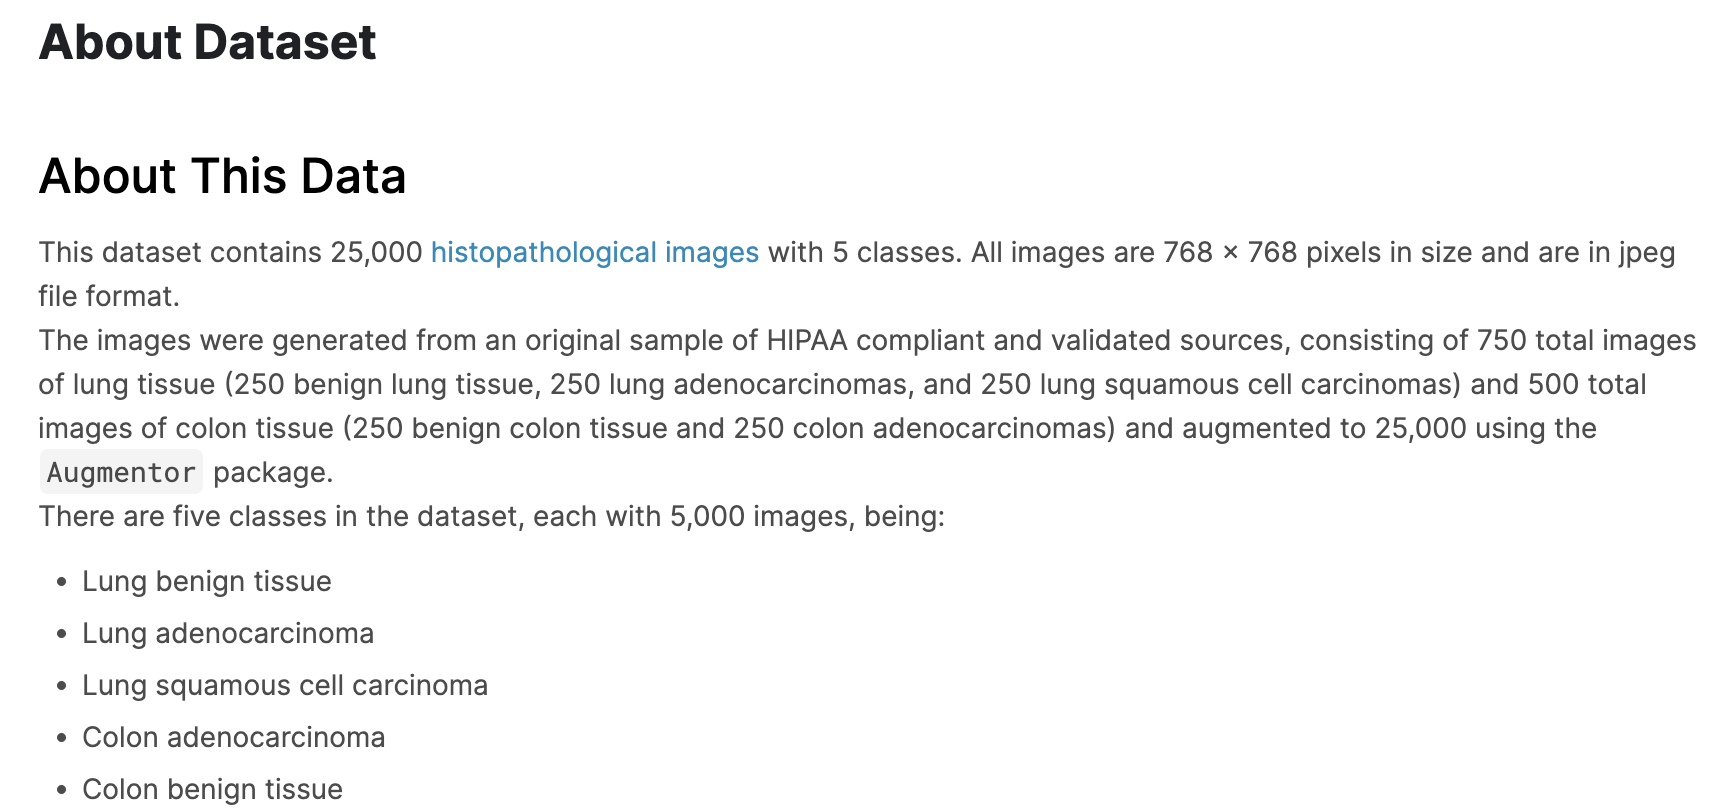

In [4]:
!wget https://github.com/smha-Promedius/pythonlibs/raw/master/images_vit/colon_vs_lung.zip
w = !unzip colon_vs_lung.zip

--2022-12-06 11:26:06--  https://github.com/smha-Promedius/pythonlibs/raw/master/images_vit/colon_vs_lung.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/smha-Promedius/pythonlibs/master/images_vit/colon_vs_lung.zip [following]
--2022-12-06 11:26:06--  https://raw.githubusercontent.com/smha-Promedius/pythonlibs/master/images_vit/colon_vs_lung.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56240314 (54M) [application/zip]
Saving to: ‘colon_vs_lung.zip’

colon_vs_lung.zip   100%[===================>]  53.63M   268MB/s    in 0.2s    

2022-12-06 11:26:09 (268 MB/s) - ‘colon_vs_lung.zip’ sa

- train set : lung/colon (240/240)
- validation set : lung/colon (60/60)
- test set : lung/colon (60/60)

In [5]:
data_dir = './colon_vs_lung/'

train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

# 분류 클래스 설정
classes = ['colon', 'lung']

# 데이터 로더

In [6]:
# transform 의 정의

data_transforms = {
    # 검증 데이터용: 정규화만을 실시
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5)
    ]),
    # 학습 데이터용: 정규화에 RandomHorizontalFlip 과 RandomErasing 을 추가로 실시
    'train' : transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
    ])
}

In [7]:
# 학습 데이터셋

data_dir = './colon_vs_lung'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [8]:
print("Train set 개수 : ", len(dataloaders['train'].dataset))
print("Validatation set 개수 : ", len(dataloaders['valid'].dataset))

Train set 개수 :  480
Validatation set 개수 :  120


In [9]:
print(image_datasets['train'].classes)

['colon', 'lung']


In [10]:
# 테스트 데이터셋

test_data = datasets.ImageFolder(test_dir, transform=data_transforms['valid'])
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

In [11]:
print("Test set 개수 : ", len(test_loader.dataset))

Test set 개수 :  120


## 학습용 데이터 시각화

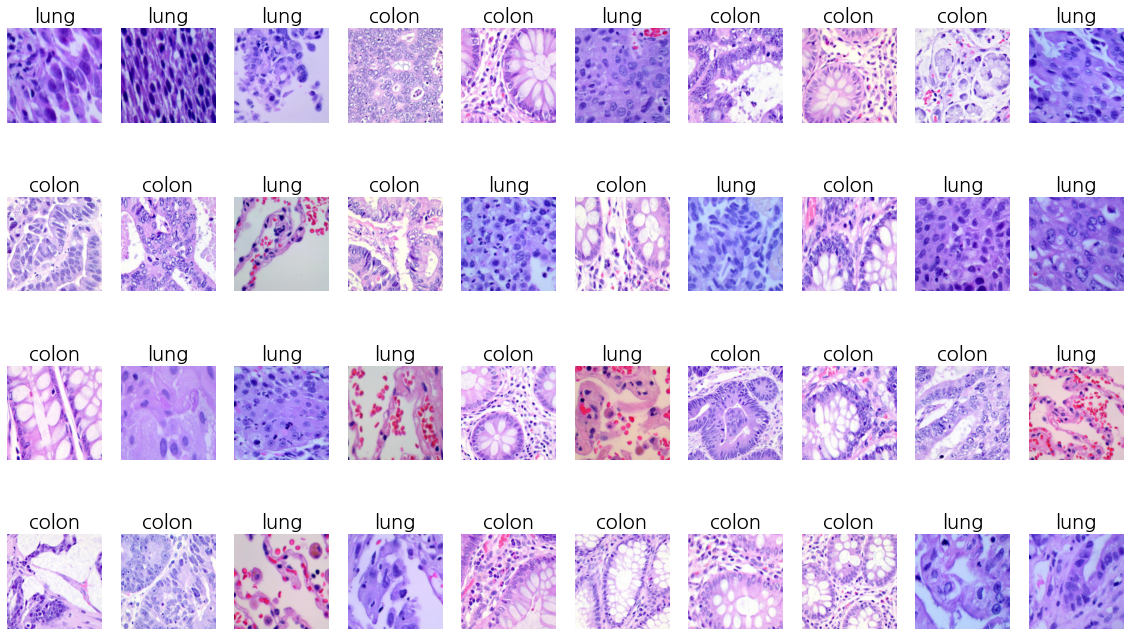

In [14]:
# 학습용 데이터 (４0건)

plt.figure(figsize=(20, 15))

train_data2 = datasets.ImageFolder(train_dir, transform=data_transforms['valid'])
train_loader2 = DataLoader(train_data2, batch_size=40, shuffle=True)


for images, labels in train_loader2:
  break

for i in range(len(images)):
    ax = plt.subplot(5, 10, i + 1)
    label_name = classes[labels[i]]
    ax.set_title(label_name, fontsize=20)
    # 텐서를 넘파이 배열로 변환
    image_np = images[i].numpy().copy()
    # 축의 순서 변경(channel, row, column) -> (row, column, channel)
    img = np.transpose(image_np, (1, 2, 0))
    # 값의 범위를[-1, 1] -> [0, 1]로 되돌림
    img = (img + 1)/2
    # 결과 출력
    plt.imshow(img)
    ax.set_axis_off()
plt.show()

# 학습하기

## Scratch 모델 사용

### Load Model

In [15]:
model_ft = models.resnet34(pretrained=False)

In [ ]:
model_ft

In [ ]:
print(model_ft.fc)

num_ftrs = model_ft.fc.in_features
print(num_ftrs)

model_ft.fc = nn.Linear(num_ftrs, 2) ## 출력 노드 설정
print(model_ft.fc)

model_ft.to(device)

### Train

In [19]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5028 Acc: 0.7729
valid Loss: 0.0560 Acc: 0.9917

Epoch 1/4
----------
train Loss: 0.3206 Acc: 0.8979
valid Loss: 0.0531 Acc: 0.9750

Epoch 2/4
----------
train Loss: 0.2672 Acc: 0.9021
valid Loss: 0.1003 Acc: 0.9583

Epoch 3/4
----------
train Loss: 0.2139 Acc: 0.9396
valid Loss: 0.1248 Acc: 0.9667

Epoch 4/4
----------
train Loss: 0.3465 Acc: 0.8854
valid Loss: 0.2241 Acc: 0.9750

Training complete in 0m 49s
Best valid Acc: 0.991667


### Test 및 성능평가

In [22]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = [] # 예측값
    y_true = [] # 실제값
    prob = [] # 모델 통과한 확률값
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted = predicted.data.cpu().detach().numpy()
        outputs = outputs.data.cpu().detach().numpy()
        labels = labels.data.cpu().detach().numpy()
        y_pred.extend(predicted)
        prob.extend(outputs)
        y_true.extend(labels)

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 100.0 %


[[60  0]
 [ 0 60]]


Text(48.0, 0.5, 'True Label')

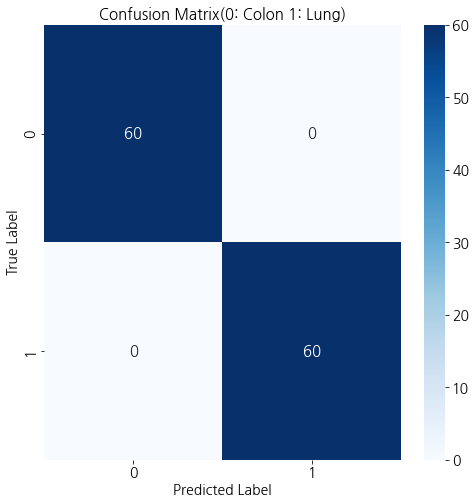

In [23]:
## Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print(cm)

plt.figure(figsize=(8,8))    
plt.title('Confusion Matrix(0: Colon 1: Lung)', fontdict={'fontsize':15})    
sns.heatmap(cm, annot=True, annot_kws={'size':15}, fmt='d', cmap='Blues')    
plt.xlabel('Predicted Label')    
plt.ylabel('True Label')

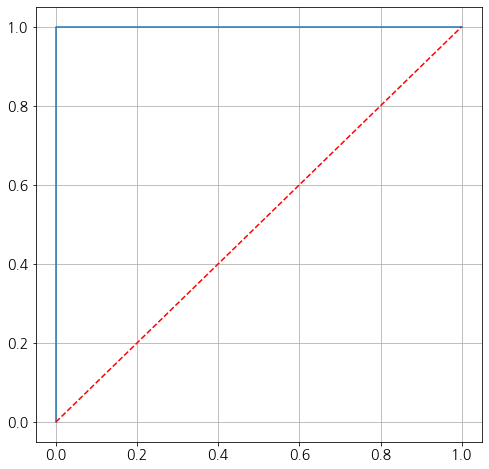

In [24]:
## Roc Curve

from sklearn.metrics import roc_curve, roc_auc_score

prob1 = [p[0] for p in prob]
fpr, tpr, _ = roc_curve(y_true, prob1)


plt.figure(figsize=(8,8))
plt.plot(tpr, fpr, label=f'AUC - {np.round(1-roc_auc_score(y_true,prob1),3)}')
plt.plot((0,1),(0,1), color='red', linestyle='--')
plt.show()

In [ ]:
!pip install scikit-plot

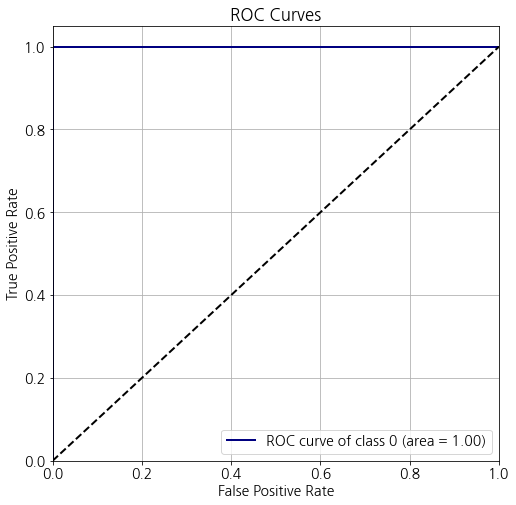

In [28]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_true, prob, plot_micro=False, plot_macro=False,
                           classes_to_plot=0,
                           figsize=(8,8),
                       cmap='jet')
plt.show()

## Pretrain 모델 사용

### Load Model

In [29]:
model_ft = models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model_ft

In [ ]:
print(model_ft.fc)

num_ftrs = model_ft.fc.in_features
print(num_ftrs)

model_ft.fc = nn.Linear(num_ftrs, 2) ## 출력 노드 설정
print(model_ft.fc)

model_ft.to(device)

### Train

In [32]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [34]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1910 Acc: 0.9104
valid Loss: 0.0091 Acc: 1.0000

Epoch 1/4
----------
train Loss: 0.1534 Acc: 0.9458
valid Loss: 0.0251 Acc: 0.9917

Epoch 2/4
----------
train Loss: 0.1371 Acc: 0.9500
valid Loss: 0.0050 Acc: 1.0000

Epoch 3/4
----------
train Loss: 0.2891 Acc: 0.9229
valid Loss: 0.2741 Acc: 0.8750

Epoch 4/4
----------
train Loss: 0.2355 Acc: 0.9313
valid Loss: 0.0016 Acc: 1.0000

Training complete in 0m 44s
Best valid Acc: 1.000000


### Test 및 성능평가

In [35]:
# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = [] # 예측값
    y_true = [] # 실제값
    prob = [] # 모델 통과한 확률값
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predicted = predicted.data.cpu().detach().numpy()
        outputs = outputs.data.cpu().detach().numpy()
        labels = labels.data.cpu().detach().numpy()
        y_pred.extend(predicted)
        prob.extend(outputs)
        y_true.extend(labels)

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 99.16666666666667 %


Text(48.0, 0.5, 'True Label')

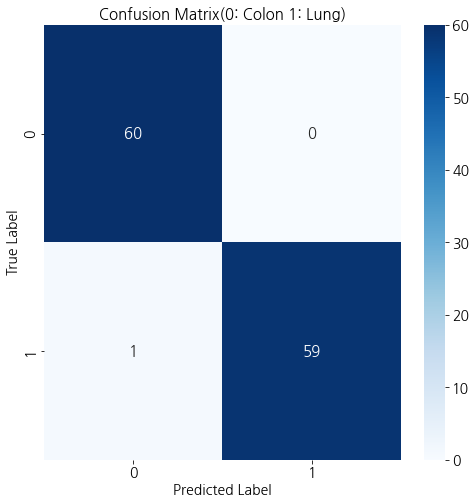

In [36]:
## Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))    
plt.title('Confusion Matrix(0: Colon 1: Lung)', fontdict={'fontsize':15})    
sns.heatmap(cm, annot=True, annot_kws={'size':15}, fmt='d', cmap='Blues')    
plt.xlabel('Predicted Label')    
plt.ylabel('True Label')

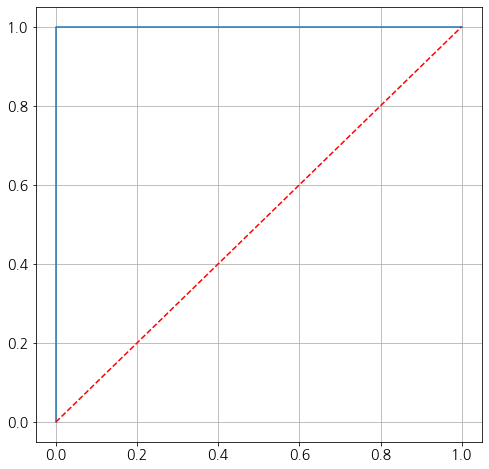

In [37]:
## Roc Curve

from sklearn.metrics import roc_curve, roc_auc_score

prob1 = [p[0] for p in prob]
fpr, tpr, _ = roc_curve(y_true, prob1)


plt.figure(figsize=(8,8))
plt.plot(tpr, fpr, label=f'AUC - {np.round(1-roc_auc_score(y_true,prob1),3)}')
plt.plot((0,1),(0,1), color='red', linestyle='--')
plt.show()

In [ ]:
!pip install scikit-plot

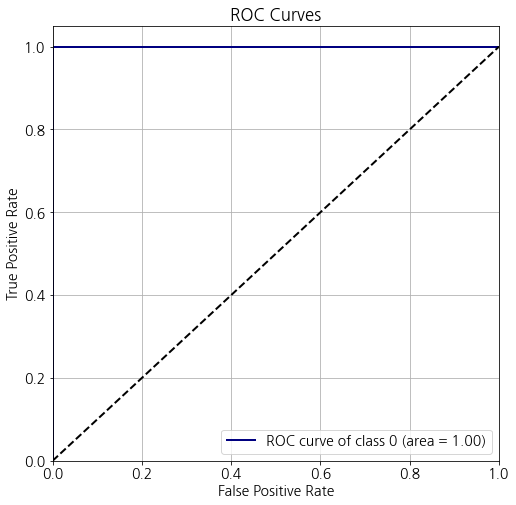

In [39]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_true, prob, plot_micro=False, plot_macro=False,
                           classes_to_plot=0,
                           figsize=(8,8),
                       cmap='jet')
plt.show()